# Event separation

## Importation

In [313]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from functools import partial
import seaborn as sns
import calendar
import matplotlib.cm as cm
import matplotlib.colors as colors

## Data Treatment

In [393]:
# Paramètres des données
Stations = ['Aigle', 'Pully', 'Payerne', 'Fretaz', 'Dole', 'Nyon', 'Moleson', 'Zermatt', 'Adelboden']
stat_index = 6
Format = ['Minutes','Heures']
form_index = 0

# Importation et fusion des années 80-95 et 95-24
file_path1 = '../Database/Precipitations/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'8095.txt'
file_path2 = '../Database/Precipitations/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'9524.txt'

df = pd.read_csv(file_path1, sep=";", low_memory=False)
df_temp = pd.read_csv(file_path2, sep=";", low_memory=False)

Overlap_num = df['time'].max()
df_temp = df_temp[df_temp['time'] > Overlap_num]
df = pd.concat([df, df_temp], ignore_index=True)

# Epuration des données et temps/value en format adapté
del df_temp
del df['stn']

df = df.replace('-',0.0)
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H%M')
df = df[~df['time'].dt.year.isin([1980, 2025])]
df = df.reset_index(drop=True)

value_column = df.columns[1]
df[value_column] = pd.to_numeric(df[value_column], errors='coerce')


## Isolating the events

In [394]:
events_pd = np.zeros(len(df[value_column]))
time_limit = 6*2
in_index = False
time_count = 0
event_count = 1
index = 0
years = df['time'].dt.year.unique()

for i, p in enumerate(df[value_column]):
    if p != 0:
        time_count = 0
        if in_index == False:
            in_index = True
            index = i            
    if p == 0:
        time_count += 1
        if time_count >= time_limit and in_index == True:
            in_index = False
            events_pd[index:i-time_limit+1] = event_count
            event_count += 1

df['events'] = events_pd

## Treating the events data

In [395]:
events_sum = df.groupby('events')[value_column].sum()
events_sum_pd = np.zeros(shape=[len(df[value_column])])
for i, e in enumerate(df['events']):
    events_sum_pd[i] = events_sum[int(e)]
df['events_sum'] = events_sum_pd

In [396]:
start_times = df.groupby('events')['time'].min()
end_times = df.groupby('events')['time'].max()
durations = np.array((end_times - start_times).dt.total_seconds())/(60*60)+(1/6)
time_btwn_events = np.zeros(len(start_times)-2)
for i in range(len(start_times)):
   if i>1:
    time_btwn_events[i-2] = (start_times[i] - end_times[i-1]).total_seconds()/(60*60)

events = df.groupby('events')['events_sum'].first().values
# Deleting the 0 event -> corresponding to time without rain
durations = np.delete(durations,0)
events = np.delete(events,0)
start_times = np.delete(start_times,0)
Intensities = events/durations
time_ratio = Intensities[:-1]/time_btwn_events

# Test of looking at the evolution through the years of the cumul of subhourly rains -> Doesn't lead to any trend
width_mobile = 10
num_mobile = years[-1]-years[0]-width_mobile
tresholds = np.arange(20,50,1)
peaks_per_year = np.zeros(shape=[num_mobile, len(tresholds)])

for i in range(num_mobile):
  for j,t in enumerate(tresholds):
    mask = (start_times<=np.datetime64(str(years[0]+i+width_mobile)+'-01-01')) & (start_times>=np.datetime64(str(years[0]+i)+'-01-01')) & (events > t)
    peaks_per_year[i,j] = len(events[mask])

<Axes: >

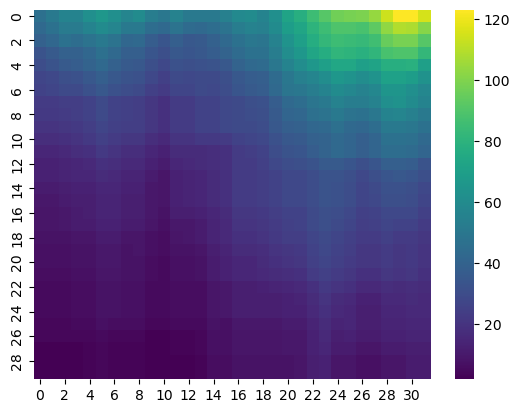

In [397]:
sns.heatmap(peaks_per_year.transpose(), cmap='viridis')

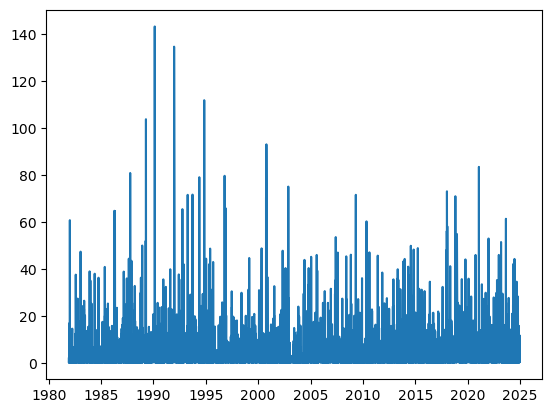

In [390]:
plt.plot(start_times,events)

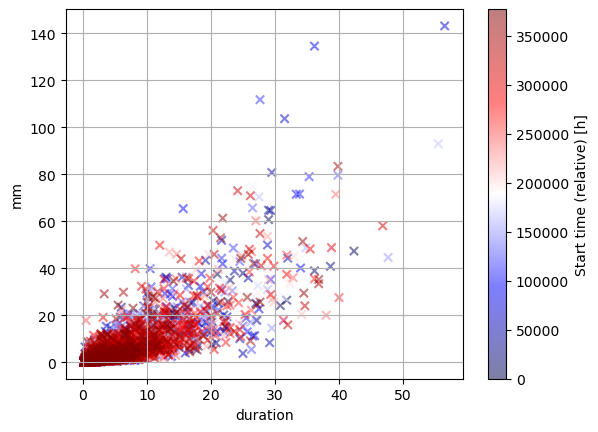

In [391]:
start_times_numeric = (start_times - start_times.min()) / np.timedelta64(1, 'h')
norm = colors.Normalize(vmin=start_times_numeric.min(), vmax=start_times_numeric.max())
colormap = cm.seismic  # ou autre colormap
mapped_colors = colormap(norm(start_times_numeric))

# Création du scatter plot avec couleurs
fig, ax = plt.subplots()
sc = ax.scatter(durations, events, c=start_times_numeric, cmap=colormap, norm=norm, marker='x', alpha=0.5)

# Ajout de la colorbar avec l'objet mappable 'sc'
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Start time (relative) [h]')

# Autres éléments du graphique
ax.grid(True)
ax.set_xlabel('duration')
ax.set_ylabel('mm')
plt.show()


In [392]:
indices = np.where(durations > 80)[0]
print(indices)

[]


## Test of FFT on the event time serie

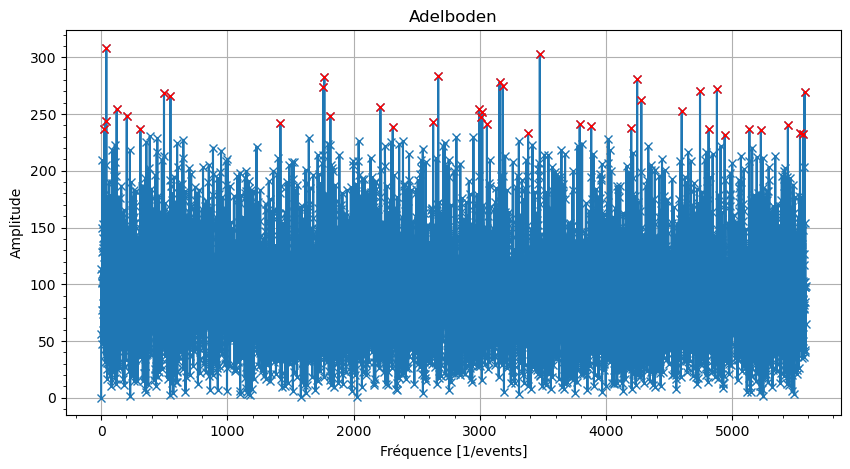

In [384]:
signal = (np.array(events) - np.mean(events))/np.std(events)
fft_vals = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(len(signal), 1/len(signal))

half_n = len(signal) // 2
fft_vals_clean = np.abs(fft_vals[:half_n])
fft_freqs_clean = fft_freqs[:half_n]

high_val_filter = 0
high_freq_filter = 100

plt.figure(figsize=(10, 5))
plt.plot(fft_freqs_clean[fft_vals_clean>high_val_filter], fft_vals_clean[fft_vals_clean>high_val_filter], 'x-')
plt.plot(fft_freqs_clean[fft_vals_clean>np.max(fft_vals_clean*0.75)], fft_vals_clean[fft_vals_clean>np.max(fft_vals_clean*0.75)], 'xr')
plt.title("Spectre de fréquence")
plt.xlabel("Fréquence [1/events]")
plt.ylabel("Amplitude")
plt.title(Stations[stat_index])
plt.minorticks_on()
plt.grid(True)
plt.show()

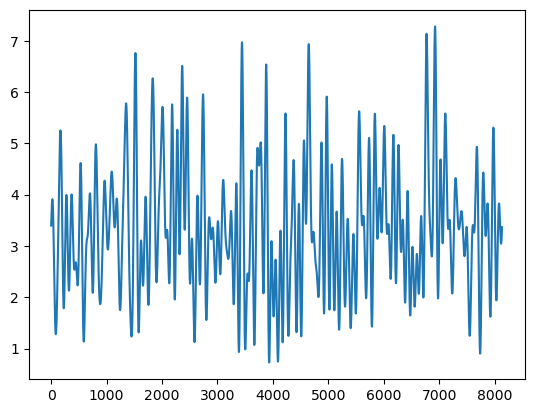

In [362]:
fft_vals[np.abs(fft_vals)<high_val_filter] = 0
fft_vals[np.abs(fft_freqs)>high_freq_filter] = 0
new_signal = np.real(np.fft.ifft(fft_vals))*np.std(events)+np.mean(events)
plt.plot(new_signal)